In [1]:
import numpy as np
import pickle
import os

def load_data(file):
   
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape
    
    # Reshape the data to have a new axis of length `window_size`
    new_length = dshape[-1] // window_size
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    
    # Average across the new axis (the last one, `axis=-1`)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    
    # Adjust the time array to match the new length
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

def upper(df):

    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [2]:
### plotting settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('image', cmap='viridis')

plt.rcParams.update({
    "font.family": "serif",  
    # use serif/main font for text elements
    })
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'axes.linewidth': 2.5})
plt.rcParams.update({'axes.labelweight': 'bold'})
plt.rcParams.update({'axes.labelsize': 20})
plt.rc('legend',fontsize=12)

In [9]:
sub = 16
eeg_data = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, "fix"))
eeg_data = average_across_points(eeg_data, window_size=10)
time = eeg_data["time"]
main_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/"
decoding_data = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_{:04d}.pickle".format(sub))


loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0016_fix.pickle
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_decoding_0016.pickle


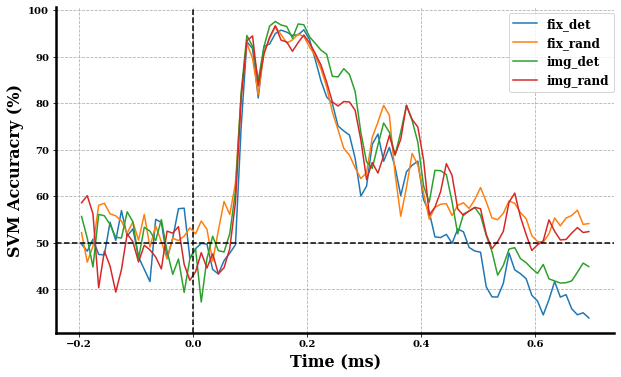

In [10]:
plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('viridis')

# Plot each key with a distinct color
for key in decoding_data.keys():
    vec = []
    for t in range(decoding_data[key].shape[-1]):
        vec.append(np.nanmean(decoding_data[key][:, :, t]) * 100)
    plt.plot(time, vec, label=key)


plt.grid(True, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
plt.axhline(y=50, color='k', linestyle='--')
plt.axvline(x=0.0, color='k', linestyle='--')
plt.xlabel("Time (ms)", fontsize = 16)
plt.ylabel("SVM Accuracry (%)", fontsize = 16)


plt.savefig(os.path.join(main_folder, f"results/{sub:02d}_SVM_decoding.png"))

In [9]:
differences = {}
conditions = list(decoding_data.keys())

for cA in range(len(conditions)):
    for cB in range(cA+1, len(conditions)):
        name = "{}-{}".format(conditions[cA], conditions[cB])
        differences[name] = []
        for t in range(len(time)):
            cA_values = np.nanmean(decoding_data[conditions[cA]][:, :, t]) * 100
            cB_values = np.nanmean(decoding_data[conditions[cB]][:, :, t]) * 100
            differences[name].append(cA_values - cB_values)
            
            

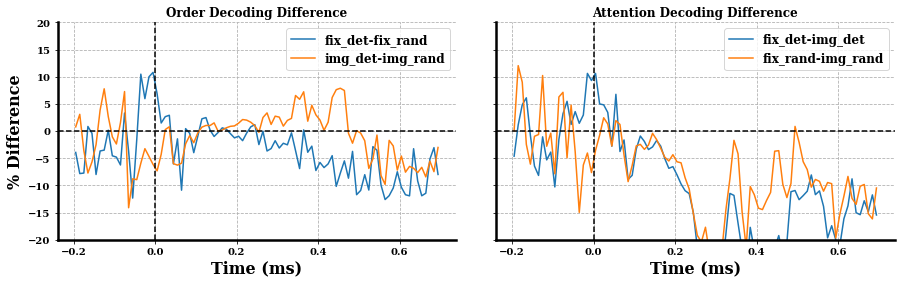

In [17]:
order_diff = ["fix_det-fix_rand", "img_det-img_rand"]
attention_diff = ["fix_det-img_det", "fix_rand-img_rand"]


fig, axes = plt.subplots(1, 2, gridspec_kw={'wspace':0.1, 'hspace':0},
                             sharey = True, figsize=(15, 4))

for k in order_diff:
    axes[0].plot(time, differences[k], label = k)
    
for k in attention_diff:
    axes[1].plot(time, differences[k], label = k)


axes[0].set_title("Order Decoding Difference", fontweight = "bold")
axes[0].legend()
axes[0].grid(True, linestyle='--')
axes[0].set_ylim([-20, 20])
axes[0].set_ylabel("% Difference", fontsize = 16)
axes[0].set_xlabel("Time (ms)", fontsize = 16)
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].axvline(x=0.0, color='k', linestyle='--')

axes[1].set_title("Attention Decoding Difference", fontweight = "bold")
axes[1].legend()
axes[1].grid(True, linestyle='--')
axes[1].set_xlabel("Time (ms)", fontsize = 16)
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].axvline(x=0.0, color='k', linestyle='--')

plt.savefig(os.path.join(main_folder, "results/02_SVM_decoding_differences.png"))

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0016.pickle


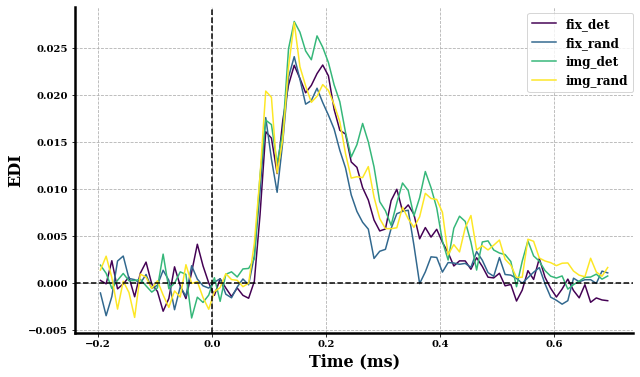

In [11]:
edi_data = load_data("/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_{:04d}.pickle".format(sub))
colors = cmap(np.linspace(0, 1, len(decoding_data.keys())))
plt.figure(figsize=(10, 6))
for i, (key, color) in enumerate(zip(edi_data.keys(), colors)):
    edi_time = []
    for t in range(len(time)):
        edi_time.append(np.mean(upper(edi_data[key][:, :, t])) - np.mean(np.diagonal(edi_data[key][:, :, t])))
    plt.plot(time, edi_time, label = key, color = color)

plt.grid(True, linestyle='--')
plt.legend(loc="upper left", bbox_to_anchor=(0.8, 1.0))
plt.axhline(y=0.0, color='k', linestyle='--')
plt.axvline(x=0.0, color='k', linestyle='--')
plt.xlabel("Time (ms)", fontsize = 16)
plt.ylabel("EDI", fontsize = 16)

plt.savefig(os.path.join(main_folder, f"results/{sub:02d}_EDI.png"))